In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import train_test_split

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pmdarima import auto_arima
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

In [2]:
df = pd.read_csv('DailyDelhiClimateTrain.csv',
                       index_col ='date',
                       parse_dates = True)
df.head()

,humidity,wind_speed,meanpressure,meantemp
date,,,,
2013-01-01,84.500000,0.000000,1015.666667,10.000000
2013-01-02,92.000000,2.980000,1017.800000,7.400000
2013-01-03,87.000000,4.633333,1018.666667,7.166667
2013-01-04,71.333333,1.233333,1017.166667,8.666667
2013-01-05,86.833333,3.700000,1016.500000,6.000000


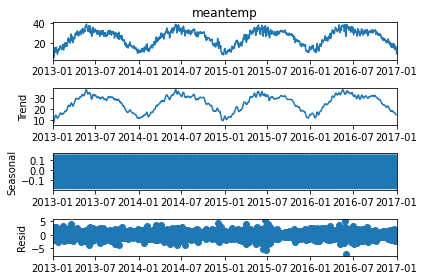

In [3]:
df_columns_length = len(df.columns)
target_col_name = df.columns[df_columns_length - 1]

decompose_data = seasonal_decompose(df[target_col_name], model="additive")
decompose_data.plot();
#seasonality.plot()

In [4]:
def extend_dataset(forecast_days):
    index_count = 0
    new_df = df.copy()
    for column in df.columns:
        stepwise_fit = auto_arima(df[column], start_p = 1, start_q = 1,
                              max_p = 1, max_q = 1, m = 12,
                              start_P = 0, seasonal = True,
                              d = None, D = 1, trace = True,
                              error_action ='ignore',   
                              suppress_warnings = True,  
                              stepwise = True)           

        best_params = stepwise_fit.get_params()

        model = sm.tsa.statespace.SARIMAX(df[column], 
                            order = best_params["order"], 
                            seasonal_order = best_params["seasonal_order"])
        result = model.fit()

        forecast = result.predict(start = len(df), 
                                  end = (len(df)-1) + forecast_days, 
                                  typ = 'levels').rename('Forecast')
    
        if (index_count == 0):
            idx = pd.date_range(df.index.max(),forecast.index.max()).union(df.index)
            new_df = df.reindex(idx)
        
        new_df[column] = new_df[column].fillna(forecast)
        index_count += 1
    return new_df

In [5]:
def create_model_prediction(model_name):
    forecast_days = int(input("How many days you want to predict?: "))
    new_df = extend_dataset(forecast_days)

    columns = new_df.columns
    train_columns = columns[:-1]
    test_columns = columns[-1:]
    X = new_df[train_columns]
    Y = new_df[test_columns]

    x_train = X[:len(df)]
    x_test = X[len(df):]
    y_train = Y[:-forecast_days]
    y_test = Y[-forecast_days:]
    
    if(model_name == "linear"):
        
        x_train = sm.add_constant(x_train)

        results = sm.OLS(y_train, x_train).fit()

        #sonuclar.summary()
        x_test = sm.add_constant(x_test)

        y_preds = results.predict(x_test)
        return (y_preds, y_test)
        
    elif(model_name == "asd"):
        model = VAR(new_df)
        num_columns = len(new_df.columns)
        results = model.fit(maxlags=num_columns, ic='aic')
        lag_order = results.k_ar
        y_preds = results.forecast(new_df.values[-lag_order:], len(x_test))
        y_preds = y_preds[:, -1]
        print(y_preds)
        return (y_preds, y_test)



In [6]:
model_type = input("Which model do you want to use?")
result_prediction, results= create_model_prediction(model_type)

Which model do you want to use?linear
How many days you want to predict?: 50
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11954.442, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10636.473, Time=0.93 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11024.214, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11952.449, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10986.809, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10486.219, Time=2.85 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.21 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11788.171, Time=1.52 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=10488.218, Time=3.17 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=11026.889, Time=2.06 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=10484.220, Time=0.79 sec
 ARIMA(1,0,0)(

In [7]:
result_prediction.index

DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09',
               '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13',
               '2017-01-14', '2017-01-15', '2017-01-16', '2017-01-17',
               '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-21',
               '2017-01-22', '2017-01-23', '2017-01-24', '2017-01-25',
               '2017-01-26', '2017-01-27', '2017-01-28', '2017-01-29',
               '2017-01-30', '2017-01-31', '2017-02-01', '2017-02-02',
               '2017-02-03', '2017-02-04', '2017-02-05', '2017-02-06',
               '2017-02-07', '2017-02-08', '2017-02-09', '2017-02-10',
               '2017-02-11', '2017-02-12', '2017-02-13', '2017-02-14',
               '2017-02-15', '2017-02-16', '2017-02-17', '2017-02-18',
               '2017-02-19', '2017-02-20'],
              dtype='datetime64[ns]', freq='D')

In [8]:
result_prediction

2017-01-02    18.632458
2017-01-03    18.992794
2017-01-04    17.625322
2017-01-05    17.233745
2017-01-06    16.823493
2017-01-07    20.480532
2017-01-08    23.777527
2017-01-09    22.844324
2017-01-10    21.699291
2017-01-11    20.612350
2017-01-12    21.558214
2017-01-13    21.168630
2017-01-14    22.739087
2017-01-15    21.048926
2017-01-16    20.147717
2017-01-17    20.393077
2017-01-18    19.527106
2017-01-19    22.805813
2017-01-20    24.793877
2017-01-21    23.354755
2017-01-22    21.823267
2017-01-23    21.226384
2017-01-24    22.692850
2017-01-25    22.076969
2017-01-26    23.497233
2017-01-27    22.034586
2017-01-28    19.725105
2017-01-29    19.620170
2017-01-30    18.188307
2017-01-31    21.988913
2017-02-01    24.266967
2017-02-02    23.154737
2017-02-03    20.865262
2017-02-04    20.186645
2017-02-05    21.278305
2017-02-06    19.557528
2017-02-07    21.674965
2017-02-08    20.734111
2017-02-09    19.167911
2017-02-10    19.074050
2017-02-11    18.153128
2017-02-12    21

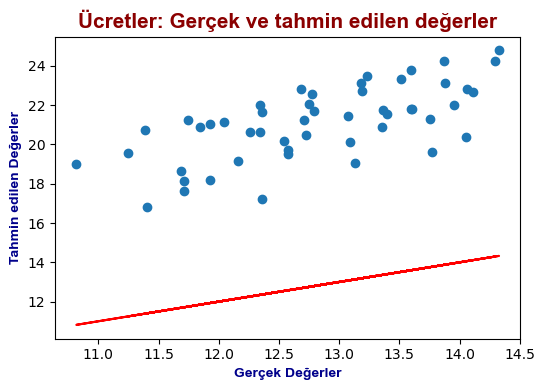

In [12]:
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(results, result_prediction)
plt.plot(results, results, color="red")
plt.xlabel("Gerçek Değerler", fontdict=eksen_font)
plt.ylabel("Tahmin edilen Değerler", fontdict=eksen_font)
plt.title("Ücretler: Gerçek ve tahmin edilen değerler", fontdict=baslik_font)
plt.show()

In [16]:
forecast_days = int(input("How many days you want to predict?: "))
new_df = extend_dataset(50)

How many days you want to predict?: 50
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11954.442, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10636.473, Time=0.92 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11024.214, Time=0.82 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11952.449, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10986.809, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10486.219, Time=2.68 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.97 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.64 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11788.171, Time=1.47 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=10488.218, Time=3.11 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=11026.889, Time=1.99 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=10484.220, Time=0.73 sec
 ARIMA(1,0,0)(1,1,0)[12]             : AIC=10634.474

In [17]:
new_df

,humidity,wind_speed,meanpressure,meantemp
2013-01-01,84.500000,0.000000,1015.666667,10.000000
2013-01-02,92.000000,2.980000,1017.800000,7.400000
2013-01-03,87.000000,4.633333,1018.666667,7.166667
2013-01-04,71.333333,1.233333,1017.166667,8.666667
2013-01-05,86.833333,3.700000,1016.500000,6.000000
...,...,...,...,...
2017-02-16,80.670871,5.642907,1017.976962,12.339921
2017-02-17,76.859471,7.226635,1016.814220,13.604825
2017-02-18,79.827413,5.738986,1015.766057,11.841823
2017-02-19,75.935253,10.506878,1014.542572,12.777204


In [43]:
columns = new_df.columns
train_columns = columns[:-1]
test_columns = columns[-1:]
X = new_df[train_columns]
Y = new_df[test_columns]

In [55]:
X

,humidity,wind_speed,meanpressure
2013-01-01,84.500000,0.000000,1015.666667
2013-01-02,92.000000,2.980000,1017.800000
2013-01-03,87.000000,4.633333,1018.666667
2013-01-04,71.333333,1.233333,1017.166667
2013-01-05,86.833333,3.700000,1016.500000
...,...,...,...
2017-02-16,80.670871,5.642907,1017.976962
2017-02-17,76.859471,7.226635,1016.814220
2017-02-18,79.827413,5.738986,1015.766057
2017-02-19,75.935253,10.506878,1014.542572


In [57]:

x_train = X[:len(df)]
x_test = X[len(df):]
y_train = Y[:-50]
y_test = Y[-50:]

In [62]:
x_train = sm.add_constant(x_train)

sonuclar = sm.OLS(y_train, x_train).fit()

sonuclar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               meantemp   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     248.5
Date:                Tue, 23 Nov 2021   Prob (F-statistic):          3.02e-130
Time:                        00:20:47   Log-Likelihood:                -4687.9
No. Observations:                1462   AIC:                             9384.
Df Residuals:                    1458   BIC:                             9405.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.9617      1.168     34.202      0.000      37.670      42.254
humidity        -0.2331      0.010    -23.159      0.000      -0.253      -0.213
wind_speed       0.1720      0.037      4.648      0.000       0.099       0.245
meanpressure    -0.0015      0.001     -1.675      0.094      -0.003       0.000
==============================================================================
Omnibus:                      222.528   Durbin-Watson:                   0.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.862
Skew:                          -0.183   Prob(JB):                     1.00e-13
Kurtosis:                       2.079   Cond. No.                     7.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [63]:
x_test = sm.add_constant(x_test)

y_preds = sonuclar.predict(x_test)

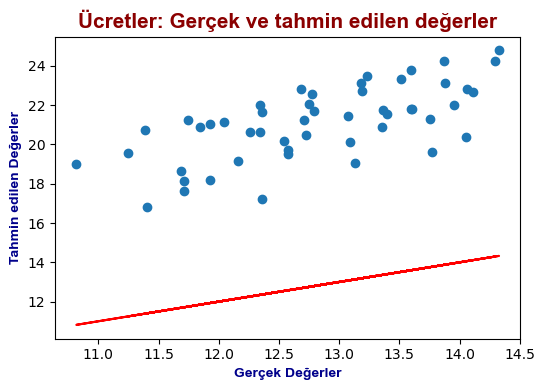

In [64]:
baslik_font = {'family': 'arial','color':  'darkred','weight': 'bold','size': 15 }
eksen_font = {'family': 'arial','color':  'darkblue','weight': 'bold','size': 10 }
plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Gerçek Değerler", fontdict=eksen_font)
plt.ylabel("Tahmin edilen Değerler", fontdict=eksen_font)
plt.title("Ücretler: Gerçek ve tahmin edilen değerler", fontdict=baslik_font)
plt.show()

#print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
#print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_preds)))
#print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_preds)))
#print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [65]:
y_preds

2017-01-02    18.632458
2017-01-03    18.992794
2017-01-04    17.625322
2017-01-05    17.233745
2017-01-06    16.823493
2017-01-07    20.480532
2017-01-08    23.777527
2017-01-09    22.844324
2017-01-10    21.699291
2017-01-11    20.612350
2017-01-12    21.558214
2017-01-13    21.168630
2017-01-14    22.739087
2017-01-15    21.048926
2017-01-16    20.147717
2017-01-17    20.393077
2017-01-18    19.527106
2017-01-19    22.805813
2017-01-20    24.793877
2017-01-21    23.354755
2017-01-22    21.823267
2017-01-23    21.226384
2017-01-24    22.692850
2017-01-25    22.076969
2017-01-26    23.497233
2017-01-27    22.034586
2017-01-28    19.725105
2017-01-29    19.620170
2017-01-30    18.188307
2017-01-31    21.988913
2017-02-01    24.266967
2017-02-02    23.154737
2017-02-03    20.865262
2017-02-04    20.186645
2017-02-05    21.278305
2017-02-06    19.557528
2017-02-07    21.674965
2017-02-08    20.734111
2017-02-09    19.167911
2017-02-10    19.074050
2017-02-11    18.153128
2017-02-12    21

In [56]:
x_train

,const,humidity,wind_speed,meanpressure
2016-06-01,1.0,42.200000,9.133333,1002.733333
2013-11-23,1.0,77.857143,0.800000,1014.571429
2014-09-27,1.0,46.875000,8.800000,1009.250000
2014-04-28,1.0,27.875000,10.187500,1005.625000
2014-06-04,1.0,33.125000,7.187500,998.125000
...,...,...,...,...
2015-02-03,1.0,71.250000,7.175000,1020.500000
2015-04-16,1.0,58.250000,8.112500,1013.875000
2016-05-01,1.0,23.375000,8.575000,1002.437500
2014-07-14,1.0,67.875000,6.725000,997.125000
